In [16]:
import gym
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple, deque
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
gym.__version__

'0.19.0'

In [18]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc_units=600, fc1_units=300):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

        self.bn1 = nn.BatchNorm1d(fc_units)
        self.bn2 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):

        self.fc2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu((self.bn1(self.fc1(state))))
        x = F.relu((self.bn2(self.fc2(x))))
        return F.torch.tanh(self.fc3(x))


In [19]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=600, fcs2_units=300, fca1_units=300):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fcs2 = nn.Linear(fcs1_units, fcs2_units)
        self.fca1 = nn.Linear(action_size, fca1_units)
        self.fc1 = nn.Linear(fcs2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):

        self.fcs2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu((self.bn1(self.fcs1(state))))
        xs = self.fcs2(xs)
        xa = self.fca1(action)
        x = F.relu(torch.add(xs, xa))
        return self.fc1(x)

In [20]:
BUFFER_SIZE = 1000000      # replay buffer size
BATCH_SIZE = 100           # minibatch size
GAMMA = 0.99               # discount factor
TAU = 0.001                # for soft update of target parameters
LR_ACTOR = 0.0001          # learning rate of the actor
LR_CRITIC = 0.001          # learning rate of the critic
WEIGHT_DECAY = 0.001       # L2 weight decay

In [21]:
device = torch.device("cpu")

In [22]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [23]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.4, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [24]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [25]:
env = gym.make('BipedalWalker-v3')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=0)

In [26]:
def ddpg(episodes, step, pretrained, noise):

    if pretrained:
        agent.actor_local.load_state_dict(torch.load('DDPG/pretrained/1checkpoint_actor.pth', map_location="cpu"))
        agent.critic_local.load_state_dict(torch.load('DDPG/pretrained/1checkpoint_critic.pth', map_location="cpu"))
        agent.actor_target.load_state_dict(torch.load('DDPG/pretrained/1checkpoint_actor_t.pth', map_location="cpu"))
        agent.critic_target.load_state_dict(torch.load('DDPG/pretrained/1checkpoint_critic_t.pth', map_location="cpu"))

    reward_list = []

    for i in range(episodes):
        state = env.reset()
        score = 0

        for t in range(step):

            env.render()

            action = agent.act(state, noise)
            next_state, reward, done, info = env.step(action[0])
            # agent.step(state, action, reward, next_state, done)
            state = next_state.squeeze()
            score += reward

            if done:
               # print('Reward: {} | Episode: {}/{}'.format(score, i, episodes))
                print('Episode ', i,'finished with reward:', score)
                print('Finished at timestep ', t)
                break

        reward_list.append(score)

        if score >= 300:
            print('Task Solved')
            torch.save(agent.actor_local.state_dict(), 'DDPG/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'DDPG/checkpoint_critic.pth')
            torch.save(agent.actor_target.state_dict(), 'DDPG/checkpoint_actor_t.pth')
            torch.save(agent.critic_target.state_dict(), 'DDPG/checkpoint_critic_t.pth')
            break

    torch.save(agent.actor_local.state_dict(), 'DDPG/checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'DDPG/checkpoint_critic.pth')
    torch.save(agent.actor_target.state_dict(), 'DDPG/checkpoint_actor_t.pth')
    torch.save(agent.critic_target.state_dict(), 'DDPG/checkpoint_critic_t.pth')

    print('Training saved')
    return reward_list


In [27]:
scores = ddpg(episodes=500, step=2000, pretrained=1, noise=0)

Episode  0 finished with reward: -57.90125704766312
Finished at timestep  271
Episode  1 finished with reward: -101.51089261756636
Finished at timestep  76
Episode  2 finished with reward: 71.31467756961868
Finished at timestep  730
Episode  3 finished with reward: -86.26668634370172
Finished at timestep  176
Episode  4 finished with reward: -49.478400780729196
Finished at timestep  255
Episode  5 finished with reward: -80.29139848800313
Finished at timestep  181
Episode  6 finished with reward: -80.67967670414535
Finished at timestep  174
Episode  7 finished with reward: -78.26299587684869
Finished at timestep  189
Episode  8 finished with reward: -82.09032867889788
Finished at timestep  199
Episode  9 finished with reward: 72.09883356911953
Finished at timestep  716
Episode  10 finished with reward: -49.17253475702259
Finished at timestep  443
Episode  11 finished with reward: -35.39643796825651
Finished at timestep  354
Episode  12 finished with reward: -6.580678478017816
Finished a

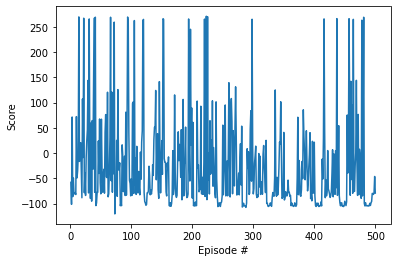

In [28]:
fig = plt.figure()
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

C:\Users\user\miniconda3\envs\ce802\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


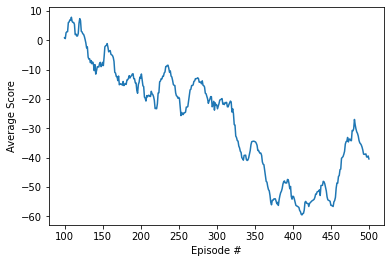

In [29]:
agent.actor_local.load_state_dict(torch.load('C:/Users/user/weights/DDPG/checkpoint_actor.pth', map_location="cpu"))
agent.critic_local.load_state_dict(torch.load('C:/Users/user/weights/DDPG/checkpoint_critic.pth', map_location="cpu"))
agent.actor_target.load_state_dict(torch.load('C:/Users/user/weights/DDPG/checkpoint_actor_t.pth', map_location="cpu"))
agent.critic_target.load_state_dict(torch.load('C:/Users/user/weights/DDPG/checkpoint_critic_t.pth', map_location="cpu"))

<All keys matched successfully>

In [32]:
time.sleep(1) #human is slow.
state = env.reset()
agent.reset()   
total_reward = 0
ep_len = 0
noise = 1
while True:
    action = agent.act(state, noise)
    env.render()
    next_state, reward, done, info = env.step(action[0])
    state = next_state.squeeze()
    total_reward += reward
    if done:
        print(ep_len)
        break
    ep_len += 1
print(f"Reward:{total_reward}")

393
Reward:-10.383074243123758
